**Дисклеймер:** весь текст этой тетрадки переведу на английский после успешной реализации.

In [1]:
import pandas as pd
import warnings
import os
from pmdarima import auto_arima
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#PATH = r"C:\Users\Никита\Андан\Project\data"
PATH = r"/Users/andrewnizov/Desktop/АнДан/Проект"

In [2]:
fintech = pd.read_csv('fintech.csv')
industrial_goods = pd.read_csv('industrial_goods.csv')
renewable_energy = pd.read_csv('renewable_energy.csv')
healthcare_services = pd.read_csv('healthcare_services.csv')

## Description of the variables

## Processing of Nans/passes

**Структура тетрадки:**
1) Смотрим на общее количество пропусков
2) На примере сектора fintech с обоснованиями обрабатываем все признаки (помимо котировок)
3) По аналогии создаем функцию для оставшихся 3 секторов (уже без подробных комментариев)
4) По очереди исследуем и обрабатываем акции всех секторов
5) Добавляем обработку через ARIMA


In [3]:
print(f'Initial (total) amount of NaNs')
print()
print(f'In fintech data: {fintech.isna().sum().sum()}')
print(f'In industrial goods data: {industrial_goods.isna().sum().sum()}')
print(f'In renewable energy data: {renewable_energy.isna().sum().sum()}')
print(f'In healthcare services data: {healthcare_services.isna().sum().sum()}')

Initial (total) amount of NaNs

In fintech data: 208642
In industrial goods data: 209596
In renewable energy data: 94342
In healthcare services data: 178072


Сайт FMP позволяет парсить котировки американских акций только за последние 5 лет. В связи с этим создадим вспомогательные переменные

In [4]:
the_day_of_parsing = pd.to_datetime('2024-05-08', format='%Y-%m-%d')
threshold = the_day_of_parsing - pd.DateOffset(years=5)

## Fintech

In [5]:
fintech['date'] = pd.to_datetime(fintech['date'], format='%Y-%m-%d')
fintech.shape

(1976, 293)

In [6]:
fintech.isna().sum().sort_values(ascending=False)

close_MBNK_RU      1968
volume_MBNK_RU     1968
close_CARM_RU      1758
volume_CARM_RU     1758
volume_CRBG_USA    1562
                   ... 
m0_ru                29
m1_ru                29
m2_ru                29
effr                 29
date                  0
Length: 293, dtype: int64

**Первый шаг обработки:** для удобства определения причины пропусков создадим столбец-признак `is_workday`, который принимает два значения: True в будни и False в выходные/праздники. Для этого обратимся к данным из календаря, который мы спарсили ранее.

In [7]:
calendar = pd.read_csv('data/trading_calendat_NYSE.csv')
calendar.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
calendar['Date'] = pd.to_datetime(calendar['Date'], format='%Y-%m-%d')
calendar['Date'].dtype

dtype('<M8[ns]')

**Первый шаг исследования:** посмотрев на таблицу, мы поняли, что надо снова отсечь данные по дате на 5 лет ранее момента парсинга, потому что FMP дает данные о котировках только за последние 5 лет.

In [9]:
#дату (месяц/день) надо менять в зависимости от момента парсинга!!

# ВТОРАЯ СТРОЧКА В ЭТОМ БЛОКЕ ПОКА НЕ РАБОТАЕТ (причина не ясна, результат плачевный)
work_calendar = calendar[calendar['Date'] > threshold]
fintech['is_workday'] = [i in work_calendar['Date'].dt.date for i in fintech['date'].dt.date]
fintech = fintech[fintech['date'] > threshold]

In [10]:
work_calendar['Date']

1346   2019-05-09
1347   2019-05-10
1348   2019-05-13
1349   2019-05-14
1350   2019-05-15
          ...    
2598   2024-04-30
2599   2024-05-01
2600   2024-05-02
2601   2024-05-03
2602   2024-05-06
Name: Date, Length: 1257, dtype: datetime64[ns]

**ПАЧИМУ((**

In [11]:
{i in work_calendar['Date'] for i in fintech['date']}

{False}

Для удобства исследования создадим новый столбец: день недели

In [12]:
fintech['day_of_week'] = fintech['date'].dt.day_name()

In [13]:
fintech.set_index(['date'], inplace=True)
fintech.sort_index(inplace=True)

In [14]:
fintech.head(4)

,volume_NTRS_USA,close_NTRS_USA,volume_EWBC_USA,close_EWBC_USA,volume_COIN_USA,close_COIN_USA,volume_CG_USA,close_CG_USA,volume_CARM_RU,close_CARM_RU,...,low_IMOEX,close_IMOEX,volume_IMOEX,Interbank credit market rates,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,804008.0,96.97,748222.0,50.17,NaN,NaN,593700.0,20.76,NaN,NaN,...,NaN,NaN,NaN,6.9477,3290.00,41.27,2069.61,3303.26,False,Thursday
2019-05-10,731618.0,97.56,674296.0,50.19,NaN,NaN,405600.0,20.62,NaN,NaN,...,2511.16,2514.87,3.253956e+10,NaN,3156.00,36.81,1848.23,3472.75,False,Friday
2019-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.3560,NaN,NaN,NaN,NaN,False,Saturday
2019-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.3851,3046.02,35.11,1874.03,3836.81,False,Sunday


**Наблюдение:** после парсинга данных о `S&P500` и `imoex` от каждого появилось по 5 показателей (`high`, `low`, `open`, `close`, `volume`). Мы решили, что может быть польза именно от гэпов `high-low` и `close-open`, поэтому 5 показателей от каждого индекса можно заменить на 4: `volume`, `gap_hl = high-low`, `gap_co = close-open` и `close`.

In [15]:
fintech['gap_hl_S&P500'] = fintech['high_S&P500'] - fintech['low_S&P500']
fintech['gap_co_S&P500'] = fintech['close_S&P500'] - fintech['open_S&P500']
fintech['gap_hl_IMOEX'] = fintech['high_IMOEX'] - fintech['low_IMOEX']
fintech['gap_co_IMOEX'] = fintech['close_IMOEX'] - fintech['open_IMOEX']

In [16]:
fintech.drop(['high_IMOEX', 'low_IMOEX', 'open_IMOEX', 'high_S&P500', 'low_S&P500', 'open_S&P500'], axis=1, inplace=True)

In [17]:
fintech[fintech['volume_IMOEX'].isnull()].sample(5)

,volume_NTRS_USA,close_NTRS_USA,volume_EWBC_USA,close_EWBC_USA,volume_COIN_USA,close_COIN_USA,volume_CG_USA,close_CG_USA,volume_CARM_RU,close_CARM_RU,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2021-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,Sunday,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,Sunday,NaN,NaN,NaN,NaN
2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3737.0,38.88,1884.8,4647.28,False,Saturday,NaN,NaN,NaN,NaN
2022-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,Sunday,NaN,NaN,NaN,NaN
2019-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,Saturday,NaN,NaN,NaN,NaN


**Наблюдение:** большинство данных не спарсилось именно за выходные. это объясняется тем, что (почти) все отдыхают. Про праздники не будет сразу делать таких выводов, потому что там все зависит от организации.

**Решение:** избавимся от этих данных, с ними кашу не сваришь.

In [18]:
fintech = fintech[(fintech['day_of_week'] != 'Sunday') & (fintech['day_of_week'] != 'Saturday')]

In [19]:
fintech.isna().sum().sum()

39657

Также надо не забыть, что если парсинг американских акций был не сегодня, то надо отсечь данные по значению переменной `the_day_of_parsing`.

In [20]:
fintech = fintech[fintech.index <= the_day_of_parsing]

In [21]:
fintech.isna().sum().sum()

35105

In [22]:
fintech.shape

(1305, 292)

In [23]:
fintech.isna().sum().sort_values(ascending=False)

volume_MBNK_RU     1298
close_MBNK_RU      1298
volume_CARM_RU     1088
close_CARM_RU      1088
volume_CRBG_USA     891
                   ... 
m1_ru                 6
m2_ru                 6
effr                  6
is_workday            0
day_of_week           0
Length: 292, dtype: int64

In [24]:
list_of_features = fintech.isna().sum().sort_values(ascending=False).index
filtered_columns = [col for col in list_of_features if not (col.startswith('volume_') or col.startswith('close_') or (fintech[col].isna().sum() == 0))]
filtered_columns

['palladium_rates',
 'platinum_rates',
 'silver_rates',
 'gold_rates',
 'usdrub',
 'Interbank credit market rates',
 'daily_gdp',
 'daily_gdp_no_season',
 'gap_co_IMOEX',
 'gap_hl_IMOEX',
 'gap_co_S&P500',
 'gap_hl_S&P500',
 'Foreign currency in cash',
 'Loans from credit institutions',
 'Quoted shares and units and shares of investment funds',
 'Debt securities',
 'Cash on brokerage accounts',
 'Deposits',
 'Cash national currency',
 'Debt securities in the portfolio of non-residents, including promissory notes',
 'Debt of the non-financial sector and households, total',
 'Non-financial sector, total',
 'Internal borrowings, non-financial sector',
 'Credits',
 'Debt securities in the residents portfolio',
 'External borrowings, non-financial sector',
 'Loans and borrowings received from non-residents',
 'Households and NPOs, total',
 'Internal borrowings, households',
 'External borrowings, households',
 'real_gdp_usa',
 'broad_money_supply_ru',
 'm0_ru',
 'm1_ru',
 'm2_ru',
 'effr']

**Глобально** мы будем пользоваться двумя способами заполнения пропусков: наивное предсказание через `.ffill()` для признаков, на которые потенциально смотрят инвесторы для принятия решения. Делаем так, потому что они действительно опираются на предыдущие (последние доступные) значения. И прогнозирование через `ARIMA` для заполнения пропусков у макроэкономических признаков, а также того самого `PRMB`, выделенного ранее.

С помощью `.ffill()` мы обработаем следующие признаки: `usdrub`, `palladium_rates`, `platinum_rates`, `silver_rates`, `gold_rates`, `IMOEX_close`, `IMOEX_volume`, `IMOEX_gap_hl`, `IMOEX_gap_co`, `S&P500_close`, `S&P500_gap_co`, `S&P500_gap_hl`, `S&P500_volume`, `effr`.

## Исследование курсов валюты и драг металлов

**Замечание:** если исследовать возможные причины пропусков в `usdrub`, `gold_rates`, `silver_rates`, `platinum_rates` и `palladium_rates`, то стоит обратить внимание, что в 205 из 311 понедельников этих курсов не было. Не уверен, но кажется, что прикол в том, что ЦБ в пн пользуется курсов за пт **(подтверждение не смог почему-то найти)**. Но на этот день недели есть явное смещение, еще одно оправдание для использования `fill forward`.

In [25]:
fintech[~(fintech['usdrub'].isnull()) & (fintech['day_of_week'] == 'Monday')].shape

(56, 292)

In [26]:
fintech[(fintech['usdrub'].isnull()) & (fintech['day_of_week'] == 'Monday')].shape

(205, 292)

In [27]:
fintech['usdrub'] = fintech['usdrub'].ffill()
fintech['gold_rates'] = fintech['gold_rates'].ffill()
fintech['silver_rates'] = fintech['silver_rates'].ffill()
fintech['platinum_rates'] = fintech['platinum_rates'].ffill()
fintech['palladium_rates'] = fintech['palladium_rates'].ffill()

In [28]:
fintech['gold_rates'].isna().sum()

0

## Исследование IMOEX и S&P500


In [29]:
fintech[fintech['volume_IMOEX'].isnull()]

,volume_NTRS_USA,close_NTRS_USA,volume_EWBC_USA,close_EWBC_USA,volume_COIN_USA,close_COIN_USA,volume_CG_USA,close_CG_USA,volume_CARM_RU,close_CARM_RU,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,804008.0,96.97,748222.0,50.17,NaN,NaN,593700.0,20.76,NaN,NaN,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.0300,1.43,NaN,NaN
2019-06-12,2207877.0,88.01,1765096.0,43.50,NaN,NaN,281900.0,21.57,NaN,NaN,...,3025.36,35.14,1823.92,3816.07,False,Wednesday,1.4400,-0.25,NaN,NaN
2019-11-04,691773.0,103.87,1119061.0,45.43,NaN,NaN,976300.0,27.98,NaN,NaN,...,2715.75,31.73,1854.48,2884.75,False,Monday,1.0400,-0.48,NaN,NaN
2019-12-31,741362.0,106.24,1167529.0,48.70,NaN,NaN,1362600.0,32.08,NaN,NaN,...,3008.36,35.48,1896.77,3795.53,False,Tuesday,1.9800,1.33,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3031.25,35.48,1932.59,3821.40,False,Wednesday,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,1098178.0,81.48,667150.0,72.36,7191183.0,165.9800,1864387.0,44.64,NaN,NaN,...,6043.85,68.81,2689.80,2901.53,False,Friday,3.0300,-1.42,NaN,NaN
2024-03-08,1225456.0,81.81,1038029.0,76.82,21883952.0,256.6200,2165911.0,47.35,NaN,NaN,...,6814.03,78.37,2805.70,2787.94,False,Friday,7.0901,-3.74,NaN,NaN
2024-05-01,1062849.0,83.05,758016.0,75.56,10191466.0,210.0900,6031390.0,40.97,NaN,NaN,...,6872.79,80.33,2680.69,2994.67,False,Wednesday,8.3250,-1.03,NaN,NaN


У данных об `S&P500` не получилось выявить каких-то закономерностей и понять причины пропусков у данных о индексах. Поэтому просто заполним пропуски через `.ffill()`. В случае `IMOEX` есть особенный временной промежуток: март 2022 года, когда данные не обновлялись Мосбиржей. Так как нам закономерность отсутсвия данных кажется непонятной, то было принято решение обработать `IMOEX` тоже через `ARIMA`.

In [30]:
fintech['close_S&P500'] = fintech['close_S&P500'].ffill()
fintech['volume_S&P500'] = fintech['volume_S&P500'].ffill()
fintech['gap_hl_S&P500'] = fintech['gap_hl_S&P500'].ffill()
fintech['gap_co_S&P500'] = fintech['gap_co_S&P500'].ffill()

## Исследование EFFR

In [31]:
fintech['effr'].isna().sum()

6

Посмотрев, где находятся пропуски у этого признака, то увидим, что за последние даты есть все 6 Nans, что вполне естественно. В целом, можно как попрощаться с этим датами, так и заполнить их с помощью `.ffill()`

In [32]:
#fintech = fintech[fintech.index < '2024-05-01']

In [33]:
fintech['effr'] = fintech['effr'].ffill()

In [34]:
fintech.isna().sum().sum()

33048

## Common function for partial processing

In [35]:
def initial_processing(dataset):
    calendar = pd.read_csv('data/trading_calendat_NYSE.csv')
    calendar.drop(['Unnamed: 0'], axis=1, inplace=True)
    calendar['Date'] = pd.to_datetime(calendar['Date'], format='%Y-%m-%d')
    
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
    
    #создаем вспомогательный признак is_workday для наглядности, 
    work_calendar = calendar[calendar['Date'] > threshold]
    dataset['is_workday'] = [i in work_calendar['Date'].dt.date for i in dataset['date'].dt.date]
    dataset = dataset[dataset['date'] > threshold]
    dataset['day_of_week'] = dataset['date'].dt.day_name()
    dataset.set_index(['date'], inplace=True)
    dataset.sort_index(inplace=True)
    
    #создаем новые признаки для индексов IMOEX и S&P500
    dataset['gap_hl_S&P500'] = dataset['high_S&P500'] - dataset['low_S&P500']
    dataset['gap_co_S&P500'] = dataset['close_S&P500'] - dataset['open_S&P500']
    dataset['gap_hl_IMOEX'] = dataset['high_IMOEX'] - dataset['low_IMOEX']
    dataset['gap_co_IMOEX'] = dataset['close_IMOEX'] - dataset['open_IMOEX']
    dataset.drop(['high_IMOEX', 'low_IMOEX', 'open_IMOEX', 'high_S&P500', 'low_S&P500', 'open_S&P500'], axis=1, inplace=True)
    
    #избавляемся от выходных и выбираем нужный временной промежуток
    dataset = dataset[(dataset['day_of_week'] != 'Sunday') & (dataset['day_of_week'] != 'Saturday')]
    dataset = dataset[dataset.index <= the_day_of_parsing]
    
    #обработка драг металлов и крус валюты
    dataset['usdrub'] = dataset['usdrub'].ffill()
    dataset['gold_rates'] = dataset['gold_rates'].ffill()
    dataset['silver_rates'] = dataset['silver_rates'].ffill()
    dataset['platinum_rates'] = dataset['platinum_rates'].ffill()
    dataset['palladium_rates'] = dataset['palladium_rates'].ffill()

    #обработка imoex и s&p500
    dataset['close_S&P500'] = dataset['close_S&P500'].ffill()
    dataset['volume_S&P500'] = dataset['volume_S&P500'].ffill()
    dataset['gap_hl_S&P500'] = dataset['gap_hl_S&P500'].ffill()
    dataset['gap_co_S&P500'] = dataset['gap_co_S&P500'].ffill()
    
    #обработка effr
    dataset['effr'] = dataset['effr'].ffill()
    return dataset

### Применяем функцию для оставшихся 3 секторов:

In [36]:
industrial_goods = initial_processing(industrial_goods)
renewable_energy = initial_processing(renewable_energy)
healthcare_services = initial_processing(healthcare_services)

## Исследование данных о котировках акций

**Замечание:** заметим, что по акциям некоторых компаний практически нет данных. Так случилось из-за того, что конкретно те сайты, откуда мы доставали котировки, не хранили их по этим компаниям, может, компании слишком непопулярны, либо их акции начали торговаться гораздо позже 2019 года и тд

**Со многими** акциями подобных компаний мы попрощаемся в рамках нашего исследования. Для удобства резделим данные на те, где пропусков больше 500 и где пропусков от 150 до 500 (этот промежуток требует более пристального рассмотрения, потому что они имеют больший шанс остаться с ручным заполнением пропусков).

## Fintech
P.S. В целом, все выводы, сделанные тут универсальны для следующих секторов (если не считать конкретизацию вплоть до названия акции).

In [37]:
ft_exceptions = list(fintech.isna().sum()[fintech.isna().sum() < 500].index)
fintech_1 = fintech.loc[:, ~fintech.columns.isin(ft_exceptions)]
fintech_1.isna().sum().sort_values(ascending=False)

volume_MBNK_RU     1298
close_MBNK_RU      1298
volume_CARM_RU     1088
close_CARM_RU      1088
close_CRBG_USA      891
volume_CRBG_USA     891
close_TPG_USA       723
volume_TPG_USA      723
close_POSI_RU       722
volume_POSI_RU      702
close_SPBE_RU       702
volume_NU_USA       699
close_NU_USA        699
volume_SPBE_RU      682
close_RENI_RU       682
volume_RENI_RU      661
volume_HOOD_USA     606
close_HOOD_USA      606
close_RYAN_USA      601
volume_RYAN_USA     601
close_COIN_USA      532
volume_COIN_USA     532
dtype: int64

In [38]:
ft_many_nans_1 = list(fintech_1.isna().sum().sort_values(ascending=False).index)

Исследуем некоторые акции по отдельности: почему у них так много пропусков?

**Описание процесса:** предполагаемых причин начилия большого количества пропусков было несколько: либо компания появилась на финансовом рынке совсем недавно (относительно промежутка 2019-2024 год), либо, в случае акций российских компаний, они торговались в разных режимах (не только TQBR) - предположение на уровне гипотезы, либо конкретно тот сайт, откуда мы брали данные о котировках, не предоставлял данные за какой-то период.

Как оказалось, **причина большинства пропусков** - компания разметила акции на финансовом рынке не так давно. **Причина дисбалансов (у volume/close)** - где-то вместо пропусков спарсились нули.

In [39]:
fintech.isna().sum()[(fintech.isna().sum() > 500) | (fintech.isna().sum() < 150)].index

Index(['volume_NTRS_USA', 'close_NTRS_USA', 'volume_EWBC_USA',
       'close_EWBC_USA', 'volume_COIN_USA', 'close_COIN_USA', 'volume_CG_USA',
       'close_CG_USA', 'volume_CARM_RU', 'close_CARM_RU',
       ...
       'gold_rates', 'silver_rates', 'platinum_rates', 'palladium_rates',
       'is_workday', 'day_of_week', 'gap_hl_S&P500', 'gap_co_S&P500',
       'gap_hl_IMOEX', 'gap_co_IMOEX'],
      dtype='object', length=275)

In [40]:
ft_exceptions_1 = list(fintech.isna().sum()[(fintech.isna().sum() > 500) | (fintech.isna().sum() < 150)].index)
fintech_2 = fintech.loc[:, ~fintech.columns.isin(ft_exceptions_1)]
fintech_2.isna().sum().sort_values(ascending=False)

volume_OWL_USA                   450
close_OWL_USA                    450
close_SMLT_RU                    434
volume_SMLT_RU                   414
close_RKT_USA                    360
volume_RKT_USA                   360
close_INGR_RU                    286
volume_UWMC_USA                  282
close_UWMC_USA                   282
volume_INGR_RU                   266
close_PRMB_RU                    226
Interbank credit market rates    224
close_RDRB_RU                    219
close_TCSG_RU                    203
volume_XP_USA                    196
close_XP_USA                     196
volume_TCSG_RU                   163
dtype: int64

In [41]:
#fintech_2.isna().sum().sort_values(ascending=False).drop(['usdrub', 'palladium_rates', 'platinum_rates', 'silver_rates', 'gold_rates', 'Interbank credit market rates'])

**Промежуточный вывод:** исследовав все акции, где количество пропусков превосходит 10%, можно сказать, что почти у всех причина одна: поздний листинг на фондовом рынке. Исключениями являются `INGR` и `PRMB`: в случае `INGR` есть подозрение, что данные неправильно спарсились, либо мосбиржа долго не публиковала их; у `PRMB` пропуски идут не подряд, а эпизодически, из-за чего их можно попробовать заполнить, предварительно предсказав.

In [42]:
ft_many_nans_2 = list(fintech_2.isna().sum().sort_values(ascending=False).index)
#drop(['usdrub', 'palladium_rates', 'platinum_rates', 'silver_rates', 'gold_rates', 'Interbank credit market rates', 'close_PRMB_RU']).index)

In [43]:
ft_many_nans_2

['volume_OWL_USA',
 'close_OWL_USA',
 'close_SMLT_RU',
 'volume_SMLT_RU',
 'close_RKT_USA',
 'volume_RKT_USA',
 'close_INGR_RU',
 'volume_UWMC_USA',
 'close_UWMC_USA',
 'volume_INGR_RU',
 'close_PRMB_RU',
 'Interbank credit market rates',
 'close_RDRB_RU',
 'close_TCSG_RU',
 'volume_XP_USA',
 'close_XP_USA',
 'volume_TCSG_RU']

Котировки акций компании `INGR` мы решили выкинуть, потому что парсинг был реализован правильно и этот случай - странное исключение, которое сложно обработать.

**Итого:** избавляемся от данных о 19 акциях (`MBNK`, `CARM`, `CRBG`, `TPG`, `POSI`, `SPBE`, `NU`, `RENI`, `HOOD`, `RYAN`, `COIN`, `OWL`, `SMLT`, `RKT`, `INGR`, `UWMC`, `RDRB`, `TCSG`, `XP`)

In [44]:
all_columns_to_drop_in_ft = ft_many_nans_1 + ft_many_nans_2
fintech.drop(all_columns_to_drop_in_ft, axis=1, inplace=True)

## Industrial goods

In [45]:
industrial_goods.head()

,volume_CLH_USA,close_CLH_USA,volume_BLDR_USA,close_BLDR_USA,volume_GGG_USA,close_GGG_USA,volume_RTX_USA,close_RTX_USA,volume_GWW_USA,close_GWW_USA,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,502075.0,69.78,931345.0,16.70,476482.0,50.87,4066569.0,86.13,490500.0,273.44,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.03,1.43,NaN,NaN
2019-05-10,548266.0,69.92,1670463.0,16.48,570537.0,51.41,4214823.0,86.32,456600.0,267.69,...,3156.00,36.81,1848.23,3472.75,False,Friday,6.64,2.48,29.17,-23.29
2019-05-13,244584.0,68.00,1018554.0,15.81,542908.0,49.86,6545091.0,83.05,687600.0,259.99,...,3156.00,36.81,1848.23,3472.75,False,Monday,3.56,-1.56,25.07,-3.36
2019-05-14,450234.0,68.17,818879.0,16.08,1187857.0,48.76,4305078.0,84.32,354600.0,262.06,...,2700.50,30.86,1795.49,2807.96,False,Tuesday,3.25,1.41,57.99,53.40
2019-05-15,189946.0,68.05,875703.0,16.15,719101.0,48.90,3861588.0,84.32,363400.0,261.79,...,2724.24,30.98,1795.03,2792.26,False,Wednesday,4.41,3.47,27.39,-14.84


In [46]:
ig_exceptions = list(industrial_goods.isna().sum()[industrial_goods.isna().sum() < 500].index)
industrial_goods_1 = industrial_goods.loc[:, ~industrial_goods.columns.isin(ig_exceptions)]
industrial_goods_1.isna().sum().sort_values(ascending=False)

volume_UGLD_RU     1190
close_UGLD_RU      1190
volume_VLTO_USA    1150
close_VLTO_USA     1150
volume_PRFN_RU      993
close_PRFN_RU       993
close_UWGN_RU       651
volume_UWGN_RU      649
volume_CNM_USA      601
close_CNM_USA       601
close_SGZH_RU       557
volume_SGZH_RU      537
volume_SYM_USA      507
close_SYM_USA       507
dtype: int64

In [47]:
ig_many_nans_1 = list(industrial_goods_1.isna().sum().sort_values(ascending=False).index)

In [48]:
ig_exceptions_1 = list(industrial_goods.isna().sum()[(industrial_goods.isna().sum() > 500) | (industrial_goods.isna().sum() < 150)].index)
industrial_goods_2 = industrial_goods.loc[:, ~industrial_goods.columns.isin(ig_exceptions_1)]
industrial_goods_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates')

volume_CARR_USA    263
close_CARR_USA     263
volume_OTIS_USA    263
close_OTIS_USA     263
volume_GFL_USA     251
close_GFL_USA      251
dtype: int64

In [49]:
ig_many_nans_2 = list(industrial_goods_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates').index)

**Промежуточный вывод:** решили ли мы оставить какие-то акции?

В случае двух акций (`PRFN_RU` и `UWGN_RU`) причина пропусков отличается от остальных: они начали существовать примерно в период 2019 года или задолго до, но при этом данные спарсились за меньший временной промежуток. Так как наши парсеры реализованы верно, а акций для исследования и так много, то мы решили пропустить этот случай, посчитав, что причина в позднем появлении данных на `moex/fmp`. 

**Итого:** избавляемся от данных о 10 акциях (`UGLD`, `VLTO`, `PRFN`, `UWGN`, `CNM`, `SGZH`, `SYM`, `CARR`, `OTIS`, `GFL`).

In [50]:
all_columns_to_drop_in_ig = ig_many_nans_1 + ig_many_nans_2
industrial_goods.drop(all_columns_to_drop_in_ig, axis=1, inplace=True)

## Renewable energy

In [51]:
renewable_energy.head()

,volume_UPRO_RU,close_UPRO_RU,volume_AMTX_USA,close_AMTX_USA,volume_CEG_USA,close_CEG_USA,volume_TPIC_USA,close_TPIC_USA,volume_NXT_USA,close_NXT_USA,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,NaN,NaN,182000.0,1.13,NaN,NaN,808169.0,24.52,NaN,NaN,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.03,1.43,NaN,NaN
2019-05-10,10250000.0,2.631,142100.0,1.11,NaN,NaN,589916.0,24.37,NaN,NaN,...,3156.00,36.81,1848.23,3472.75,False,Friday,6.64,2.48,29.17,-23.29
2019-05-13,17350000.0,2.641,121000.0,1.08,NaN,NaN,621285.0,23.11,NaN,NaN,...,3156.00,36.81,1848.23,3472.75,False,Monday,3.56,-1.56,25.07,-3.36
2019-05-14,25134000.0,2.640,121800.0,1.16,NaN,NaN,767031.0,22.01,NaN,NaN,...,2700.50,30.86,1795.49,2807.96,False,Tuesday,3.25,1.41,57.99,53.40
2019-05-15,35968000.0,2.580,124000.0,1.19,NaN,NaN,523199.0,22.54,NaN,NaN,...,2724.24,30.98,1795.03,2792.26,False,Wednesday,4.41,3.47,27.39,-14.84


In [52]:
re_exceptions = list(renewable_energy.isna().sum()[renewable_energy.isna().sum() < 500].index)
renewable_energy_1 = renewable_energy.loc[:, ~renewable_energy.columns.isin(re_exceptions)]
renewable_energy_1.isna().sum().sort_values(ascending=False)

volume_GEV_USA     1275
close_GEV_USA      1275
volume_SMXT_USA    1252
close_SMXT_USA     1252
close_VSTE_USA     1208
volume_VSTE_USA    1208
volume_NXT_USA     1024
close_NXT_USA      1024
close_ENLT_USA      998
volume_ENLT_USA     998
volume_CEG_USA      726
close_CEG_USA       726
volume_ZEO_USA      704
close_ZEO_USA       704
volume_IMPP_USA     696
close_IMPP_USA      696
close_FLNC_USA      670
volume_FLNC_USA     670
dtype: int64

In [53]:
re_many_nans_1 = list(renewable_energy_1.isna().sum().sort_values(ascending=False).index)

In [54]:
re_exceptions_1 = list(renewable_energy.isna().sum()[(renewable_energy.isna().sum() > 500) | (renewable_energy.isna().sum() < 150)].index)
renewable_energy_2 = renewable_energy.loc[:, ~renewable_energy.columns.isin(re_exceptions_1)]
renewable_energy_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates')

volume_RNW_USA     482
close_RNW_USA      482
volume_SHLS_USA    479
close_SHLS_USA     479
volume_ARRY_USA    409
close_ARRY_USA     409
volume_MAXN_USA    374
close_MAXN_USA     374
close_ENPG_RU      259
volume_ENPG_RU     239
dtype: int64

In [55]:
re_many_nans_2 = list(renewable_energy_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates').index)

**Промежуточный вывод:** решили ли мы оставить какие-то акции?

В случае двух акций (`NXT_USA` и `MPP_USA`) причина пропусков, как и у `industrial goods`, отличается от остальных. Наше решение осталось неизменным. 

**Итого:** избавляемся от данных о 14 акциях (`GEV`, `SMXT`, `VSTE`, `NXT`, `ENLT`, `CEG`, `ZEO`, `MPP`, `FLNC`, `RNW`, `SHLS`, `ARRY`, `MAXN`, `ENPG`).

In [56]:
all_columns_to_drop_in_re = re_many_nans_1 + re_many_nans_2
renewable_energy.drop(all_columns_to_drop_in_re, axis=1, inplace=True)

## Healthcare services

In [57]:
healthcare_services.head()

,volume_DHR_USA,close_DHR_USA,volume_CHE_USA,close_CHE_USA,volume_COR_USA,close_COR_USA,volume_AMGN_USA,close_AMGN_USA,volume_BIO_USA,close_BIO_USA,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,2464934.0,116.42,96300.0,332.55,1774000.0,79.18,2854400.0,172.87,411176.0,309.28,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.03,1.43,NaN,NaN
2019-05-10,1791091.0,116.72,127100.0,334.63,1336100.0,77.47,2942300.0,171.85,395472.0,311.10,...,3156.00,36.81,1848.23,3472.75,False,Friday,6.64,2.48,29.17,-23.29
2019-05-13,2621471.0,114.75,171000.0,331.89,1087000.0,75.68,3371800.0,167.60,281162.0,296.28,...,3156.00,36.81,1848.23,3472.75,False,Monday,3.56,-1.56,25.07,-3.36
2019-05-14,1984989.0,115.90,117700.0,329.33,1605100.0,76.69,2525300.0,167.81,274589.0,291.97,...,2700.50,30.86,1795.49,2807.96,False,Tuesday,3.25,1.41,57.99,53.40
2019-05-15,1860640.0,116.16,58300.0,332.69,1333300.0,77.86,2860200.0,169.87,182146.0,294.35,...,2724.24,30.98,1795.03,2792.26,False,Wednesday,4.41,3.47,27.39,-14.84


In [58]:
hs_exceptions = list(healthcare_services.isna().sum()[healthcare_services.isna().sum() < 500].index)
healthcare_services_1 = healthcare_services.loc[:, ~healthcare_services.columns.isin(hs_exceptions)]
healthcare_services_1.isna().sum().sort_values(ascending=False)

volume_ABIO_RU     1122
close_ABIO_RU      1122
close_GECO_RU      1043
volume_GECO_RU     1042
volume_GEHC_USA     955
close_GEHC_USA      955
close_GEMC_RU       640
volume_STVN_USA     597
close_STVN_USA      597
volume_GEMC_RU      592
dtype: int64

In [59]:
hs_many_nans_1 = list(healthcare_services_1.isna().sum().sort_values(ascending=False).index)

In [60]:
hs_exceptions_1 = list(healthcare_services.isna().sum()[(healthcare_services.isna().sum() > 500) | (healthcare_services.isna().sum() < 150)].index)
healthcare_services_2 = healthcare_services.loc[:, ~healthcare_services.columns.isin(hs_exceptions_1)]
healthcare_services_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates')

volume_ROIV_USA    446
close_ROIV_USA     446
close_MDMG_RU      442
volume_MDMG_RU     420
volume_CERE_USA    355
close_CERE_USA     355
volume_RPRX_USA    324
close_RPRX_USA     324
volume_PCVX_USA    322
close_PCVX_USA     322
dtype: int64

In [61]:
hs_many_nans_2 = list(healthcare_services_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates').index)

**Промежуточный вывод:** решили ли мы оставить какие-то акции?

В случае одной акции (`ABIO_RU`) причина пропусков, как и у предыдущих секторов, отличается от остальных. Наше решение осталось неизменным. 

**Итого:** избавляемся от данных о 10 акциях (`ABIO`, `GECO`, `GEHC`, `STVN`, `GEMC`, `ROIV`, `MDMG`, `CERE`, `RPRX`, `PCVX`).

In [62]:
all_columns_to_drop_in_hs = hs_many_nans_1 + hs_many_nans_2
healthcare_services.drop(all_columns_to_drop_in_hs, axis=1, inplace=True)

# ARIMA model

Interpolation with ARIMA consists of 4 steps:
1. For each column algorithm finds the first date that contains no missing values
2. Each column is filled with simple interpolation: `.ffill()` method
3. ARIMA is automatically fitted to each column
4. Missing values are filled with ARIME predictions

**NB!** Make sure indices of input DataFrame are dates sorted in ascending order.

In [63]:
def interpolate(series):
    '''
    series: pd.Series
    '''
    series_filled = series.fillna(method = 'ffill')
    series_filled = series_filled.fillna(method = 'bfill')
    model = auto_arima(series_filled, seasonal=True, 
                       stepwise=True, suppress_warnings=True, 
                       error_action="ignore", trace=False)
    model.fit(series_filled)
    forecast = model.predict_in_sample()
    interpolated_series = series.copy()
    interpolated_series[series.isna()] = forecast[series.isna()]

    return interpolated_series

def find_first_date(series):
    '''
    series: pd.Series with dates as indices in ascending order

    returns
    Datetime - first data with no nans
    '''
    return series.index.values[~series.isnull()][0]

def interpolate_df(df, column_list):
    '''
    Function finds the first date with no nans for all chosen columns
    and interpolate time series since this date
    
    df: pd.DataFrame with dates as indices in ascending order
    column_list: str[] - columns to interpolate

    returns
    pd.DataFrame
    '''
    first_date = max([find_first_date(df[col]) for col in column_list])
    df = df[df.index >= first_date]
    df.loc[:, column_list] = df[column_list].apply(lambda x: interpolate(x), axis=0)
    
    return df

def process_df(df, path):
    '''
    Function finds the first date with no nans for all chosen columns
    and interpolate time series since this date

    df: pd.DataFrame
    path: path to \data\{sector}

    returni
    pd.DataFrame
    '''
    ticker_names = os.listdir(path)
    columns_names = list(set([col for col in df.columns for ticker_name in ticker_names if ticker_name[:-4] in col]))
    columns_names += [col for col in df.columns if ('IMOEX' in col) or ('S&P500' in col)]
    columns_names += ['m0_ru', 'm1_ru', 'm2_ru', 'broad_money_supply_ru']
    columns_names += ['Cash national currency', 'Foreign currency in cash', 
                     'Deposits', 'Cash on brokerage accounts',
                     'Debt securities', 'Quoted shares and units and shares of investment funds',
                     'Loans from credit institutions']
    
    columns_names += [
    "Debt of the non-financial sector and households, total",
    "Non-financial sector, total",
    "Internal borrowings, non-financial sector",
    "Credits",
    "Debt securities in the residents portfolio",
    "External borrowings, non-financial sector",
    "Loans and borrowings received from non-residents",
    "Debt securities in the portfolio of non-residents, including promissory notes",
    "Households and NPOs, total",
    "Internal borrowings, households",
    "External borrowings, households"
]

    return interpolate_df(df, columns_names)
    

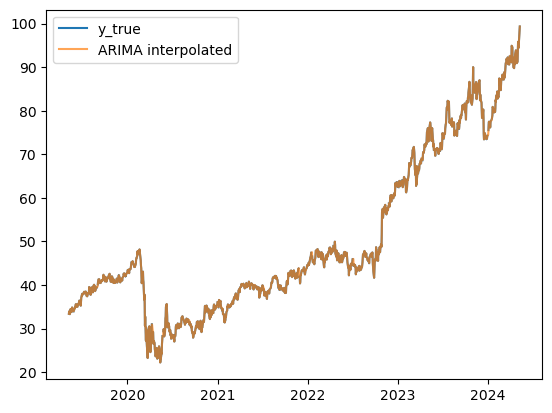

In [64]:
# That's why it's important to exclude first dates with missing values 
series = fintech['close_ACGL_USA']
interpolated = interpolate(series)

plt.plot(series, label = 'y_true')
plt.plot(interpolated, label = 'ARIMA interpolated', alpha = 0.7)
plt.legend();

In [67]:
fintech.isna().sum().sum()

11010

In [65]:
df = process_df(fintech, os.path.join(PATH, 'fintech'))
df.to_csv('final_fintech.csv', encoding = 'utf-8')

KeyboardInterrupt: 